In [1]:
import os
import toml
import pandas as pd
from utils.config_helper import update_nested_toml, load_config

breast
lung
prostate
stomach
rectal

In [2]:
TYPE = input("Enter the type of the config file: ")
CONFIG_PATH = f"../config/{TYPE}.toml"
config = load_config(CONFIG_PATH)

In [3]:
def inspect_nan(df, name):
    print(df[pd.isna(df[name])])

In [4]:
beta_file_number = config["init"]["hyper"]["beta_file_number"]
test_ratio = config["init"]["hyper"]["test_ratio"]
seed = config["init"]["hyper"]["splitting_seed"]
normal_number_0 = config["init"]["hyper"]["normal_number_0"]
if beta_file_number == 2:
    normal_number_1 = config["init"]["hyper"]["normal_number_1"]
data_source = config["init"]["hyper"]["data_source"]
is_columns_duplicated = config["init"]["hyper"]["is_columns_duplicated"]
if data_source == "GDC_stomach_GSE99553":  # god forgive me
    is_columns_duplicated_1 = config["init"]["hyper"]["is_columns_duplicated_1"]

In [5]:
trainOutPath = f"../{TYPE}/result/{data_source}/train{int(100-test_ratio*100)}"
testOutPath = f"../{TYPE}/result/{data_source}/test{int(test_ratio*100)}"

### Section. 0 Merge and Split Champ Data 
(if there are more than one normalized beta data)

#### Summary
- beta data is split into train and test
- all beta data will the following format
  - column 0 is the id of the sample
  - column 1 to n is the beta value of each CpG site
  - normal samples come first, then tumor samples

In [6]:
df0 = pd.read_csv(f"../{TYPE}/champ_result/{data_source}/all_beta_normalized_0.csv")

In [7]:
if beta_file_number == 2:
    df1 = pd.read_csv(f"../{TYPE}/champ_result/{data_source}/all_beta_normalized_1.csv")

In [8]:
# DEBUG
df0
# END

,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,785,786,787,788,789,790,791,792,793,794
0,cg00000957,0.882586,0.882586,0.888966,0.888966,0.855526,0.855526,0.832959,0.832959,0.856065,...,0.923578,0.923578,0.881459,0.881459,0.736260,0.736260,0.874344,0.874344,0.842226,0.842226
1,cg00001349,0.785839,0.785839,0.797948,0.797948,0.504743,0.504743,0.819827,0.819827,0.664534,...,0.928798,0.928798,0.869638,0.869638,0.771485,0.771485,0.841111,0.841111,0.860493,0.860493
2,cg00001583,0.132020,0.132020,0.389871,0.389871,0.039702,0.039702,0.051382,0.051382,0.029278,...,0.094878,0.094878,0.085176,0.085176,0.052560,0.052560,0.767299,0.767299,0.021839,0.021839
3,cg00002028,0.044290,0.044290,0.036263,0.036263,0.031440,0.031440,0.052714,0.052714,0.031140,...,0.034089,0.034089,0.025052,0.025052,0.047492,0.047492,0.064969,0.064969,0.033071,0.033071
4,cg00002719,0.078922,0.078922,0.151968,0.151968,0.309160,0.309160,0.224937,0.224937,0.016472,...,0.077611,0.077611,0.621762,0.621762,0.376571,0.376571,0.812937,0.812937,0.599716,0.599716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375932,cg27634744,0.964502,0.964502,0.959192,0.959192,0.959986,0.959986,0.908966,0.908966,0.950377,...,0.959669,0.959669,0.975149,0.975149,0.964513,0.964513,0.957571,0.957571,0.972283,0.972283
375933,cg27648216,0.613667,0.613667,0.773861,0.773861,0.467030,0.467030,0.520283,0.520283,0.449169,...,0.595399,0.595399,0.477862,0.477862,0.652910,0.652910,0.138486,0.138486,0.968375,0.968375
375934,cg27657537,0.095200,0.095200,0.111093,0.111093,0.089802,0.089802,0.070704,0.070704,0.050406,...,0.054031,0.054031,0.051604,0.051604,0.106537,0.106537,0.026094,0.026094,0.057825,0.057825
375935,cg27662611,0.035588,0.035588,0.058057,0.058057,0.051713,0.051713,0.131603,0.131603,0.032566,...,0.109315,0.109315,0.054413,0.054413,0.058714,0.058714,0.030267,0.030267,0.045827,0.045827


In [9]:
# DEBUG
df1
# END

,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,75,76,77,78,79,80,81,82,83,84
0,cg00000957,0.858035,0.857628,0.867186,0.863948,0.876811,0.891727,0.857704,0.839934,0.875310,...,0.853386,0.874006,0.870364,0.898049,0.843260,0.856604,0.865932,0.858620,0.897222,0.869239
1,cg00001349,0.818526,0.815122,0.820965,0.798571,0.837677,0.865194,0.809122,0.758602,0.747747,...,0.805034,0.844716,0.777586,0.791153,0.784364,0.807629,0.820862,0.803123,0.857963,0.733382
2,cg00001583,0.069695,0.101148,0.251718,0.167441,0.320355,0.066808,0.070955,0.074023,0.089597,...,0.343598,0.219374,0.123079,0.091969,0.092934,0.152514,0.182412,0.086743,0.243569,0.147689
3,cg00002028,0.050951,0.039571,0.049801,0.038430,0.044819,0.030731,0.053750,0.063628,0.044394,...,0.048357,0.049542,0.038441,0.045066,0.053866,0.059476,0.065169,0.054855,0.055633,0.047655
4,cg00002719,0.030276,0.034636,0.120129,0.063254,0.165408,0.031822,0.025926,0.031782,0.046754,...,0.201393,0.129438,0.038857,0.032211,0.046372,0.090776,0.067066,0.058569,0.113084,0.079253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411031,cg27656573,0.963091,0.958470,0.963696,0.959347,0.954072,0.968240,0.942136,0.952305,0.964950,...,0.941491,0.946809,0.934101,0.962496,0.949366,0.963563,0.965538,0.962758,0.966208,0.955197
411032,cg27657363,0.934041,0.935863,0.921512,0.932295,0.933304,0.943195,0.918545,0.913295,0.938081,...,0.910818,0.923547,0.915725,0.929228,0.910335,0.925806,0.927480,0.911182,0.931382,0.928196
411033,cg27657537,0.075093,0.052161,0.096838,0.102040,0.105938,0.073159,0.066998,0.085528,0.092740,...,0.130149,0.094656,0.079995,0.056742,0.071605,0.083873,0.077076,0.080459,0.078748,0.101048
411034,cg27662611,0.023245,0.029685,0.034149,0.019497,0.033785,0.037193,0.030691,0.023716,0.043504,...,0.026529,0.026026,0.038393,0.027462,0.036888,0.032922,0.024665,0.046806,0.035739,0.035194


In [10]:
# potential feature loss
if beta_file_number == 2:
    feature_name_0 = df0.iloc[:, 0].tolist()
    feature_name_1 = df1.iloc[:, 0].tolist()

    feature_name = list(set(feature_name_0).intersection(feature_name_1))
    update_nested_toml(
        "preprocess.merge_and_split", "feature_size_0", len(feature_name_0)
    )
    update_nested_toml(
        "preprocess.merge_and_split", "feature_size_1", len(feature_name_1)
    )
    update_nested_toml(
        "preprocess.merge_and_split", "feature_size_intersection", len(feature_name)
    )
elif beta_file_number == 1:
    feature_name = df0.iloc[:, 0].tolist()
    update_nested_toml(
        "preprocess.merge_and_split", "feature_size_0", len(feature_name)
    )

In [11]:
if beta_file_number == 2:
    df0_join = df0[df0.iloc[:, 0].isin(feature_name)]
    df1_join = df1[df1.iloc[:, 0].isin(feature_name)]

In [12]:
if beta_file_number == 2:
    df0_join = df0_join.iloc[:, 1::is_columns_duplicated]
    if data_source == "GDC_stomach_GSE99553":  # god forgive me
        df1_join = df1_join.iloc[:, 1::is_columns_duplicated_1]
    else:
        df1_join = df1_join.iloc[:, 1::is_columns_duplicated]
    df0_join.reset_index(drop=True, inplace=True)
    df1_join.reset_index(drop=True, inplace=True)
    df0_join_normal = df0_join.iloc[:, :normal_number_0]
    df0_join_tumor = df0_join.iloc[:, normal_number_0:]
    df1_join_normal = df1_join.iloc[:, :normal_number_1]
    df1_join_tumor = df1_join.iloc[:, normal_number_1:]
elif beta_file_number == 1:
    df0_join = df0.iloc[:, 1::is_columns_duplicated]

In [13]:
if beta_file_number == 2:
    df_normal = pd.concat([df0_join_normal, df1_join_normal], axis=1)
    df_tumor = pd.concat([df0_join_tumor, df1_join_tumor], axis=1)

In [14]:
# drop those samples with missing value
# note: could use padding or other methods to fill the missing value

if beta_file_number == 2:
    update_nested_toml(
        "preprocess.merge_and_split", "Before_dropna_dfn_shape", df_normal.shape
    )
    update_nested_toml(
        "preprocess.merge_and_split", "Before_dropna_dfc_shape", df_tumor.shape
    )
    df_normal.dropna(inplace=True, axis=1)
    df_tumor.dropna(inplace=True, axis=1)
    update_nested_toml(
        "preprocess.merge_and_split", "After_dropna_dfn_shape", df_normal.shape
    )
    update_nested_toml(
        "preprocess.merge_and_split", "After_dropna_dfc_shape", df_tumor.shape
    )
elif beta_file_number == 1:
    update_nested_toml(
        "preprocess.merge_and_split", "Before_dropna_df_shape", df0_join.shape
    )
    df0_join.dropna(inplace=True, axis=1)
    update_nested_toml(
        "preprocess.merge_and_split", "After_dropna_df_shape", df0_join.shape
    )

In [15]:
from imblearn.over_sampling import SMOTE

# Combine the normal and tumor data
if beta_file_number == 2:
    X = pd.concat([df_normal, df_tumor], axis=1).T
    y = [0] * df_normal.shape[1] + [1] * df_tumor.shape[1]
elif beta_file_number == 1:
    X = df0_join.T
    y = [0] * normal_number_0 + [1] * (df0_join.shape[1] - normal_number_0)
update_nested_toml(
    "preprocess.merge_and_split", "Before_SMOTE_X_shape", X.shape
)
update_nested_toml(
    "preprocess.merge_and_split", "Before_SMOTE_y_shape", len(y)
)


In [16]:
smote = SMOTE(random_state=seed)
X_resampled, y_resampled = smote.fit_resample(X, y)
update_nested_toml(
    "preprocess.merge_and_split", "After_SMOTE_X_shape", X_resampled.shape
)
update_nested_toml(
    "preprocess.merge_and_split", "After_SMOTE_y_shape", len(y_resampled)
)

In [17]:
# DEBUG
X_resampled
# END

,0,1,2,3,4,5,6,7,8,9,...,375372,375373,375374,375375,375376,375377,375378,375379,375380,375381
0,0.882586,0.785839,0.132020,0.044290,0.078922,0.305587,0.009150,0.159651,0.940844,0.013428,...,0.811774,0.130897,0.870209,0.014249,0.224858,0.964502,0.613667,0.095200,0.035588,0.851922
1,0.888966,0.797948,0.389871,0.036263,0.151968,0.362442,0.010007,0.260364,0.960472,0.020536,...,0.869211,0.061715,0.894518,0.013156,0.201473,0.959192,0.773861,0.111093,0.058057,0.802420
2,0.858035,0.818526,0.069695,0.050951,0.030276,0.439639,0.017651,0.165369,0.944982,0.029455,...,0.739420,0.075303,0.704384,0.026629,0.112338,0.949519,0.388190,0.075093,0.023245,0.832204
3,0.857628,0.815122,0.101148,0.039571,0.034636,0.306618,0.014986,0.157741,0.946624,0.015107,...,0.622299,0.067601,0.778526,0.020871,0.048750,0.978058,0.299649,0.052161,0.029685,0.780789
4,0.867186,0.820965,0.251718,0.049801,0.120129,0.386672,0.013293,0.221143,0.937167,0.031028,...,0.769739,0.072415,0.782371,0.030878,0.291471,0.950844,0.672361,0.096838,0.034149,0.814076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,0.904989,0.875588,0.182052,0.048328,0.085871,0.321603,0.011674,0.202204,0.959965,0.034006,...,0.784302,0.076807,0.830119,0.031548,0.220733,0.963007,0.552476,0.070538,0.042786,0.856046
786,0.871992,0.799793,0.168759,0.060355,0.098747,0.341540,0.013164,0.198616,0.951975,0.021868,...,0.779914,0.105440,0.865041,0.020436,0.254468,0.954288,0.561132,0.098692,0.039243,0.827468
787,0.854138,0.804452,0.338828,0.048796,0.198682,0.363103,0.013056,0.250402,0.941074,0.009111,...,0.758298,0.126634,0.828418,0.015914,0.224901,0.927456,0.616830,0.130683,0.028236,0.840169
788,0.869980,0.783315,0.132474,0.062800,0.063207,0.324641,0.014218,0.193350,0.944816,0.027760,...,0.744604,0.056669,0.804585,0.027533,0.173360,0.943346,0.553163,0.079034,0.027349,0.898433


In [ ]:
# config = load_config(CONFIG_PATH)
# if beta_file_number == 1:
#     normal_count = config["init"]["hyper"]["normal_number_0"]
# elif beta_file_number == 2:
#     normal_count = config["init"]["hyper"]["normal_number_0"] + config["init"]["hyper"]["normal_number_1"]
# X = df.T
# y = [(0 if i < normal_count else 1) for i in range((df.shape[1]))]

In [28]:
from collections import Counter
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=test_ratio, random_state=seed
)

train_class_distribution = Counter(y_train)
testing_class_distribution = Counter(y_test)

update_nested_toml("preprocess.merge_and_split", "training_set_samples", len(X_train))
update_nested_toml("preprocess.merge_and_split", "testing_set_samples", len(X_test))
update_nested_toml(
    "preprocess.merge_and_split",
    "training_class_distribution",
    [train_class_distribution[0], train_class_distribution[1]],
)
update_nested_toml(
    "preprocess.merge_and_split",
    "testing_class_distribution",
    [testing_class_distribution[0], testing_class_distribution[1]],
)

In [29]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,375372,375373,375374,375375,375376,375377,375378,375379,375380,375381
210,0.782682,0.787995,0.051028,0.048141,0.251292,0.303493,0.013071,0.184458,0.947209,0.031148,...,0.660994,0.045860,0.656078,0.032173,0.068789,0.976736,0.567656,0.058103,0.061629,0.722139
133,0.871723,0.869020,0.055993,0.031761,0.192108,0.264592,0.013148,0.194343,0.968845,0.020351,...,0.810782,0.050436,0.850604,0.010108,0.402215,0.971319,0.625282,0.102724,0.012510,0.806969
745,0.878139,0.739156,0.108619,0.047026,0.066724,0.331163,0.018286,0.170793,0.954718,0.037861,...,0.747065,0.090614,0.671220,0.035511,0.129368,0.952254,0.602020,0.086631,0.033981,0.842413
537,0.866853,0.741438,0.138124,0.052243,0.077809,0.347029,0.017369,0.189786,0.955829,0.047527,...,0.728460,0.111086,0.658441,0.033693,0.144207,0.953455,0.562870,0.088925,0.024705,0.855879
55,0.898812,0.845820,0.290884,0.055695,0.117762,0.387595,0.017378,0.241247,0.956743,0.026653,...,0.798766,0.066690,0.874881,0.033016,0.085557,0.945427,0.688564,0.093748,0.051394,0.830033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.870594,0.825320,0.121566,0.036038,0.026383,0.268673,0.014334,0.131210,0.957819,0.022252,...,0.664319,0.093655,0.883106,0.029266,0.099994,0.971751,0.345947,0.054004,0.038591,0.790330
106,0.923935,0.939161,0.493697,0.052971,0.408458,0.493885,0.018324,0.410547,0.970426,0.027725,...,0.901531,0.086046,0.842796,0.176985,0.738798,0.982212,0.936410,0.042581,0.074983,0.922764
270,0.858288,0.844919,0.059723,0.045727,0.075383,0.455583,0.027380,0.152862,0.946657,0.055538,...,0.817026,0.050371,0.907914,0.033700,0.095385,0.949306,0.643586,0.149585,0.055593,0.704731
435,0.886065,0.796239,0.045557,0.038013,0.147829,0.179327,0.004848,0.110893,0.959269,0.017420,...,0.799900,0.061386,0.847262,0.024480,0.036542,0.957346,0.411421,0.055983,0.043809,0.885688


In [30]:
X_train.columns = feature_name
X_train["label"] = y_train
X_train.sort_values(by=["label"], inplace=True)
train_df = X_train.T
train_df.columns = range(train_df.shape[1])

X_test.columns = feature_name
X_test["label"] = y_test
X_test.sort_values(by=["label"], inplace=True)
test_df = X_test.T
test_df.columns = range(test_df.shape[1])

train_df.insert(0, "Unnamed: 0", train_df.index)
train_df.reset_index(drop=True, inplace=True)
test_df.insert(0, "Unnamed: 0", test_df.index)
test_df.reset_index(drop=True, inplace=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_8588\2887518300.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train["label"] = y_train
C:\Users\USER\AppData\Local\Temp\ipykernel_8588\2887518300.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test["label"] = y_test


In [31]:
# DEBUG
train_df
# END

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,622,623,624,625,626,627,628,629,630,631
0,cg18023943,0.874528,0.865194,0.867086,0.865491,0.893122,0.861654,0.876736,0.853361,0.853382,...,0.843037,0.902681,0.898044,0.858088,0.863826,0.895780,0.940094,0.853151,0.863658,0.848407
1,cg05848389,0.814761,0.775596,0.820288,0.778049,0.769975,0.866011,0.834181,0.749192,0.812049,...,0.834784,0.882939,0.932707,0.692958,0.835435,0.871345,0.930512,0.832651,0.850762,0.838998
2,cg16197925,0.334911,0.156307,0.179787,0.139211,0.075050,0.087044,0.316528,0.071477,0.317478,...,0.113146,0.600093,0.252241,0.392140,0.211147,0.458216,0.074836,0.767070,0.017330,0.049935
3,cg20534884,0.043472,0.043961,0.037286,0.043178,0.040862,0.055454,0.048034,0.051384,0.049390,...,0.031828,0.020279,0.031124,0.066482,0.028662,0.559689,0.048872,0.035983,0.045449,0.054382
4,cg17900047,0.166032,0.069510,0.071616,0.042222,0.056772,0.005920,0.162969,0.031658,0.165507,...,0.384216,0.750104,0.268382,0.236890,0.153147,0.176965,0.366124,0.838983,0.030944,0.032507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375378,cg08722586,0.693845,0.528569,0.428201,0.595784,0.607432,0.372335,0.561008,0.431675,0.643915,...,0.351064,0.973346,0.857725,0.958972,0.862763,0.959727,0.836036,0.599529,0.930021,0.957246
375379,cg15191781,0.103310,0.097259,0.081294,0.068208,0.078265,0.072324,0.107263,0.090813,0.095657,...,0.034340,0.052795,0.128874,0.079199,0.069726,0.103194,0.078727,0.056621,0.063340,0.066287
375380,cg20713639,0.041710,0.021417,0.033085,0.033960,0.048019,0.022621,0.034446,0.025643,0.036159,...,0.080650,0.044526,0.067680,0.042027,0.018214,0.027126,0.108515,0.057044,0.049154,0.025791
375381,cg06486088,0.820133,0.849842,0.841131,0.891902,0.842167,0.805914,0.805166,0.764419,0.811351,...,0.815872,0.743854,0.772763,0.750685,0.803148,0.810915,0.939846,0.528865,0.874228,0.834188


In [32]:
# DEBUG
test_df
# END

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,148,149,150,151,152,153,154,155,156,157
0,cg18023943,0.870160,0.868576,0.859033,0.868010,0.887755,0.868933,0.870503,0.855558,0.890728,...,0.854115,0.881459,0.865569,0.836551,0.866008,0.729081,0.821985,0.855526,0.837620,0.888979
1,cg05848389,0.816831,0.819280,0.828265,0.781209,0.744192,0.727332,0.763293,0.842258,0.831488,...,0.737244,0.869638,0.841817,0.857540,0.798873,0.486825,0.706389,0.504743,0.822882,0.883160
2,cg16197925,0.287742,0.287836,0.076369,0.127949,0.084938,0.161644,0.198644,0.201505,0.048944,...,0.077604,0.085176,0.511593,0.374874,0.374871,0.075571,0.099595,0.039702,0.076269,0.422658
3,cg20534884,0.062621,0.060010,0.054324,0.060439,0.043157,0.047173,0.065130,0.076261,0.040832,...,0.037490,0.025052,0.042299,0.030740,0.036557,0.057688,0.042778,0.031440,0.054236,0.030785
4,cg17900047,0.158895,0.162721,0.019194,0.059399,0.054896,0.064712,0.064431,0.084625,0.039526,...,0.415066,0.621762,0.569449,0.405817,0.549004,0.086867,0.086303,0.309160,0.138307,0.331443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375378,cg08722586,0.674142,0.664462,0.344060,0.549963,0.631823,0.454319,0.524542,0.497825,0.390987,...,0.937087,0.477862,0.429936,0.741503,0.939110,0.917104,0.627387,0.467030,0.799956,0.507773
375379,cg15191781,0.108439,0.106085,0.068790,0.076401,0.082816,0.073689,0.080990,0.080169,0.077552,...,0.191381,0.051604,0.060400,0.067737,0.109895,0.063005,0.057763,0.089802,0.064156,0.065948
375380,cg20713639,0.034447,0.033119,0.027976,0.028224,0.042457,0.025929,0.042331,0.024509,0.055138,...,0.052980,0.054413,0.101950,0.054464,0.032439,0.053105,0.032074,0.051713,0.044719,0.030085
375381,cg06486088,0.816495,0.820241,0.857211,0.899444,0.828873,0.860328,0.816682,0.830915,0.892792,...,0.898944,0.894335,0.846491,0.875923,0.509446,0.819796,0.835736,0.533191,0.851902,0.748240


In [33]:
os.makedirs(f"{trainOutPath}", exist_ok=True)
os.makedirs(
    f"{testOutPath}",
    exist_ok=True,
)

train_df.to_csv(f"{trainOutPath}/all_beta_normalized_0.csv", index=False)
test_df.to_csv(f"{testOutPath}/all_beta_normalized_1.csv", index=False)

In [34]:
del train_df, test_df

In [35]:
zip_filename = f"{TYPE}_beta_files.zip"

In [36]:
import zipfile

with zipfile.ZipFile(zip_filename, "w") as zipf:
    zipf.write(
        f"{trainOutPath}/all_beta_normalized_0.csv", arcname="all_beta_normalized_0.csv"
    )
    zipf.write(
        f"{testOutPath}/all_beta_normalized_1.csv", arcname="all_beta_normalized_1.csv"
    )

In [37]:
from api import utils
service = utils.authenticate_drive()

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=260407430533-mtnvh98d2pv3eo7mgb14h6en5827k7b5.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A10560%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.file&state=fRfCt1VpWyqRdI7WXYhG8TpfRIzBGG&access_type=offline


INFO:google_auth_oauthlib.flow:"GET /?state=fRfCt1VpWyqRdI7WXYhG8TpfRIzBGG&code=4/0AanRRruvMn7ppFjFwwfucniDVGcJA4f0IiohESID1gs1IiuQwao4kO_TVIO6v-8j5PU-1g&scope=https://www.googleapis.com/auth/drive.file HTTP/1.1" 200 65
INFO:api.utils:New credentials obtained.
INFO:api.utils:Credentials saved to token.pickle.
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0


In [38]:
directory = utils.create_folder(service, TYPE)

Folder 'stomach' already exists with ID: 1SWP3wue2Oyt8ygC48wcodylK2F3ILulz


In [40]:
utils.run_upload_with_separate_thread(service, directory, zip_filename)

INFO:api.utils:Upload 0% complete for stomach_beta_files.zip
INFO:api.utils:Upload 0% complete for stomach_beta_files.zip
INFO:api.utils:Upload 0% complete for stomach_beta_files.zip
INFO:api.utils:Upload 0% complete for stomach_beta_files.zip
INFO:api.utils:Upload 0% complete for stomach_beta_files.zip
INFO:api.utils:Upload 0% complete for stomach_beta_files.zip
INFO:api.utils:Upload 0% complete for stomach_beta_files.zip
INFO:api.utils:Upload 0% complete for stomach_beta_files.zip
INFO:api.utils:Upload 0% complete for stomach_beta_files.zip
INFO:api.utils:Upload 0% complete for stomach_beta_files.zip
INFO:api.utils:Upload 1% complete for stomach_beta_files.zip
INFO:api.utils:Upload 1% complete for stomach_beta_files.zip
INFO:api.utils:Upload 1% complete for stomach_beta_files.zip
INFO:api.utils:Upload 1% complete for stomach_beta_files.zip
INFO:api.utils:Upload 1% complete for stomach_beta_files.zip
INFO:api.utils:Upload 1% complete for stomach_beta_files.zip
INFO:api.utils:Upload 1%

### Sec. 1 dbeta calculation
#### Summary
- calculate the difference of beta value between tumor and normal samples
- the output file will have the following format
  - column 0 is the id of the sample
  - column 1 is the gene name
  - column 2 is the difference of beta value between tumor and normal samples

### Implementation
1. split normal and tumor samples
2. remove outliers in normal and tumor samples
3. calculate the mean of normal sammples
4. tumor - avg(normal)
5. calculate the mean of tumor samples
6. merge with DMP file
7. exclude the genes not in single comorbidity list

In [11]:
import gdown

##### Lung
https://drive.google.com/file/d/1cuKmDUgch4A0ULnj6XfTHuk6u0Xtz_3H/view?usp=sharing
##### Rectal
https://drive.google.com/file/d/11DZAwbtqVriSN8EhUNhQEEwVyntiycRa/view?usp=sharing
##### Stomach
https://drive.google.com/file/d/1QBklKEO61ZYqxo-gfjBsWg3mcREsTRc7/view?usp=sharing
##### Prostate
tbd
##### Breast
tbd

In [ ]:
url = input()

output = 'download.zip'

In [ ]:
gdown.download(url, output, quiet=False)

In [13]:
import zipfile
import shutil

with zipfile.ZipFile("download.zip", "r") as zip_ref:
    zip_ref.extractall("download")

shutil.move("download/all_beta_normalized_0.csv", f"all_beta_normalized_0.csv")
shutil.move("download/all_beta_normalized_1.csv", f"all_beta_normalized_1.csv")

os.remove("download.zip")
shutil.rmtree("download")

In [6]:
train_df = pd.read_csv(f"{trainOutPath}/all_beta_normalized_0.csv")

In [8]:
def IQR(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    upper_fence = Q3 + IQR * 1.5
    lower_fence = Q1 - IQR * 1.5
    return upper_fence, lower_fence


def no_outlier(df):
    upper_fence, lower_fence = IQR(df)
    ddf = df[(df > lower_fence) & (df < upper_fence)]
    return ddf

In [10]:
config = load_config(CONFIG_PATH)
normal_count = config["preprocess"]["merge_and_split"]["training_class_distribution"][0]
all_beta_normalized_normal = train_df.iloc[:-1, 1 : normal_count + 1 :]


all_beta_normalized_tumor = train_df.iloc[:-1, normal_count + 1 : :]

In [11]:
all_beta_normalized_normal = no_outlier(all_beta_normalized_normal)
all_beta_normalized_tumor = no_outlier(all_beta_normalized_tumor)

In [12]:
train_normal_avg = all_beta_normalized_normal.mean(skipna=True, axis=1)

In [13]:
all_beta_normalized_tumor = (all_beta_normalized_tumor).subtract(
    train_normal_avg, axis=0
)

In [14]:
all_beta_normalized_tumor = no_outlier(all_beta_normalized_tumor)

In [15]:
train_tumor_mean = all_beta_normalized_tumor.mean(skipna=True, axis=1)

In [16]:
delta_beta = pd.merge(
    train_df.iloc[:-1, :1],
    pd.DataFrame(train_tumor_mean, columns=["dbeta"]),
    left_index=True,
    right_index=True,
)
update_nested_toml("preprocess.dbeta", "delta_beta_avg", delta_beta.shape[0])

In [17]:
# print(delta_beta[pd.isna(delta_beta["dbeta"])])
# record the list of feature with dbeta being NaN
update_nested_toml(
    "preprocess.dbeta",
    "NaN_dbeta_feature",
    delta_beta.loc[pd.isna(delta_beta["dbeta"]), "Unnamed: 0"].tolist(),
)
delta_beta.dropna(inplace=True, axis=0)
update_nested_toml("preprocess.dbeta", "delta_beta_avg_remove_NaN", delta_beta.shape[0])

In [19]:
dmp = pd.read_csv(f"../{TYPE}/champ_result/{data_source}/DMP_result_0.csv")
dmp = dmp[["Unnamed: 0", "gene", "feature"]]
update_nested_toml("preprocess.dbeta", "dmp_before_dropna_shape_feature", dmp.shape[0])
dmp.dropna(inplace=True)
update_nested_toml("preprocess.dbeta", "dmp_after_dropna_shape_feature", dmp.shape[0])

In [20]:
result = pd.merge(delta_beta, dmp, on="Unnamed: 0", how="left")
update_nested_toml(
    "preprocess.dbeta", "delta_beta_avg_remove_NaN_with_gene_name", result.shape[0]
)

In [21]:
def find_max_dBeta_grouped(group):
    idx_max = group["dbeta"].abs().idxmax()
    return group.loc[idx_max]


dbeta = result.groupby("gene", as_index=False).apply(
    find_max_dBeta_grouped, include_groups=False
)

In [22]:
dbeta.columns = ["gene", "ID", "dbeta", "feature"]
dbeta = dbeta[["ID", "gene", "dbeta", "feature"]]
# DEBUG
dbeta
# END

,ID,gene,dbeta,feature
0,cg03630821,A1BG,0.029581,Body
1,cg27199384,A2BP1,0.031936,Body
2,cg14888445,A2LD1,0.005293,Body
3,cg08300930,A2M,0.016542,Body
4,cg15384867,A2ML1,0.009407,Body
...,...,...,...,...
14414,cg04830147,ZYG11A,0.017931,TSS1500
14415,cg03935117,ZYG11B,0.019302,TSS1500
14416,cg05102190,ZYX,0.015232,TSS200
14417,cg18943946,ZZEF1,0.031702,Body


In [ ]:
# comorbidity = pd.read_csv(
#     "../external_result/matchgene174_single_3Y10__OR2.txt", sep="\t", header=None
# )
# dbeta = dbeta[
#     dbeta["gene"].isin(comorbidity[0])
# ]

# result_max_per_gene_single

In [23]:
dbeta.to_csv(f"{trainOutPath}/dbeta.csv", index=False)

### Sec. 2 Filter genes by dbeta values
1. filter genes by dbeta values
3. filter genes by TSS position
4. plot distribution of dbeta values
5. plot PCA for normal and tumor


In [ ]:
# dbeta = pd.read_csv(f"{trainOutPath}/dbeta.csv")

#### Filtering TSS

In [24]:
TSS = dbeta[dbeta["feature"].str.contains("TSS")]

In [25]:
TSS.to_csv(f"{trainOutPath}/dbeta_TSS.csv", index=False)

#### Thresholding

In [26]:
threshold = 0.5
TSS_threshold = TSS[abs(TSS["dbeta"]) > threshold]
while True:
    TSS_threshold = TSS[abs(TSS["dbeta"]) > threshold]
    count = TSS_threshold.shape[0]
    if (
        config["preprocess"]["filtering"]["hyper"]["avg_dbeta_lower_bound"]
        <= count
        <= config["preprocess"]["filtering"]["hyper"]["avg_dbeta_upper_bound"]
    ):
        break
    threshold -= 0.01
threshold = round(threshold, 2)
update_nested_toml("preprocess.filtering", "threshold", threshold)

In [27]:
TSS_threshold.to_csv(f"{trainOutPath}/dbeta_TSS_{threshold}.csv", index=False)

#### Visualization

Text(0.5, 1.0, 'Density plot of delta Beta value')

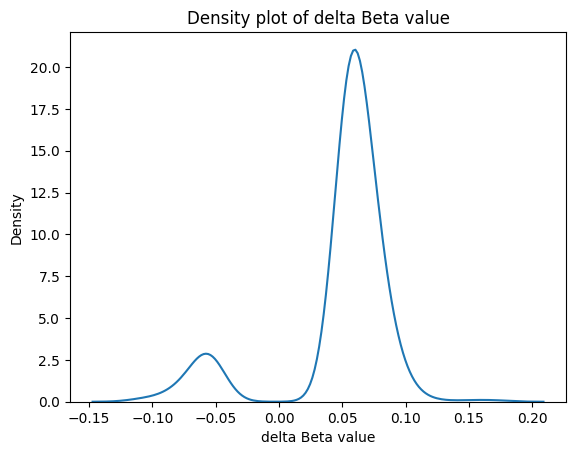

In [28]:
# DEBUG
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(TSS_threshold["dbeta"])
plt.xlabel("delta Beta value")
plt.title("Density plot of delta Beta value")
# END

In [ ]:
# train_df = pd.read_csv(f"{trainOutPath}/all_beta_normalized_0.csv")

In [29]:
normal_count = (train_df.iloc[-1, 1:] == 0).sum()
df_gene = train_df.iloc[:-1, :]
df_gene = df_gene[df_gene[df_gene.columns[0]].isin(dbeta["ID"])]
X = df_gene.iloc[:, 1:].reset_index(drop=True).T
y = [0 if i < normal_count else 1 for i in range(X.shape[0])]
# DEBUG
print(f"X shape: {X.shape}")
print(f"y shape: {len(y)}")
# END

X shape: (1083, 14419)
y shape: 1083


In [30]:
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

df = pd.DataFrame(
    {
        "Principal Component 1": X_pca[:, 0],
        "Principal Component 2": X_pca[:, 1],
        "Principal Component 3": X_pca[:, 2],
        "Class": y,
    }
)
print(df.shape)
fig = px.scatter_3d(
    df,
    x="Principal Component 1",
    y="Principal Component 2",
    z="Principal Component 3",
    color="Class",
    title="PCA of Dataset",
    color_continuous_scale="Viridis",
)

fig.update_layout(
    scene=dict(
        xaxis_title="Principal Component 1",
        yaxis_title="Principal Component 2",
        zaxis_title="Principal Component 3",
    )
)

# fig.show()

fig.write_html(f"{trainOutPath}/preprocess_filtering_pca.html")
# open in browser

(1083, 4)


### Sec. 3 Machine Learning
1. remove hypo-methylated genes
2. RFE
3. RFECV (tbd)

In [31]:
config = load_config(CONFIG_PATH)
threshold = config["preprocess"]["filtering"]["threshold"]
TSS_threshold = pd.read_csv(f"{trainOutPath}/dbeta_TSS_{threshold}.csv")

In [32]:
TSS_threshold_hyper = TSS_threshold[TSS_threshold["dbeta"] > 0]
# DEBUG
TSS_threshold_hyper
# END

,ID,gene,dbeta,feature
0,cg04911280,AARS2,0.069674,TSS200
2,cg19529696,ABCF2,0.055435,TSS200
3,cg24006936,ABT1,0.060007,TSS200
4,cg03401580,ACP6,0.063028,TSS200
6,cg02089380,ACVR1,0.066394,TSS1500
...,...,...,...,...
438,cg25404339,ZNF677,0.051339,TSS200
439,cg04910638,ZNF684,0.058628,TSS200
440,cg12440566,ZNF703,0.055607,TSS200
441,cg17010941,ZNF706,0.063776,TSS1500


In [33]:
train_df = pd.read_csv(f"{trainOutPath}/all_beta_normalized_0.csv")
test_df = pd.read_csv(f"{testOutPath}/all_beta_normalized_1.csv")

In [34]:
X_train = train_df[train_df["Unnamed: 0"].isin(TSS_threshold_hyper["ID"])]
X_test = test_df[test_df["Unnamed: 0"].isin(TSS_threshold_hyper["ID"])]

In [35]:
X_train = X_train.iloc[:, 1:].T.values.tolist()
X_test = X_test.iloc[:, 1:].T.values.tolist()

In [37]:
config = load_config(CONFIG_PATH)
normal_count_train = config["preprocess"]["merge_and_split"][
    "training_class_distribution"
][0]
normal_count_test = config["preprocess"]["merge_and_split"][
    "testing_class_distribution"
][0]
y_train = [0 if i < normal_count_train else 1 for i in range(len(X_train))]
y_test = [0 if i < normal_count_test else 1 for i in range(len(X_test))]

In [38]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    matthews_corrcoef,
    roc_auc_score,
    auc,
    roc_curve,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV

In [40]:
selection_models = {
    "XGBoost": XGBClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(kernel="linear", random_state=42),
}

param_xgb = {
    "learning_rate": [0.001, 0.01, 0.1],
    "n_estimators": [50, 100, 200],
    "max_depth": [2, 3, 4],
    "subsample": [0.6, 0.7, 0.8],
    "colsample_bytree": [0.6, 0.7, 0.8],
    "min_child_weight": [40, 50, 60],
}

param_rf = {
    "n_estimators": [50, 100, 150, 200],
    "min_samples_split": [80, 90],
    "min_samples_leaf": [80, 90],
    "max_features": [5, 10, 20],
}

param_svm = {"kernel": ["rbf", "poly", "sigmoid"], "C": [50, 100, 200]}

param_dt = {
    "min_samples_split": [70, 80, 90],
    "min_samples_leaf": [70, 80, 90],
    "max_features": [5, 10, 20],
}

def set_parameters(model: object, param_grid: dict) -> object:
    grid_search = GridSearchCV(
        estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2
    )
    return grid_search

xgb_model = set_parameters(XGBClassifier(random_state=42), param_xgb)
rf_model = set_parameters(RandomForestClassifier(random_state=42), param_rf)
svm_model = set_parameters(SVC(random_state=42), param_svm)
dt_model = set_parameters(DecisionTreeClassifier(random_state=42), param_dt)

train_models = {
    "XGBoost": xgb_model,
    "Random Forest": rf_model,
    "Decision Tree": dt_model,
    "SVM": svm_model,
}


In [43]:
def append_to_file(file_name: str, data: pd.DataFrame) -> None:
        if not os.path.isfile(file_name):
            data.to_csv(file_name, index=False)
        else:
            data.to_csv(file_name, index=False, mode="a", header=False)

def record(
    best_estimator: object,
    X: pd.DataFrame,
    y: pd.Series,
    selection_model_name: str,
    train_model_name: str,
    feature_count: int,
    best_score: float,
    best_params: dict,
    filepath: str,
) -> None:
    
    y_pred_on_X = best_estimator.predict(X)

    tn, fp, _, _ = confusion_matrix(y, y_pred_on_X).ravel()
    accuracy = accuracy_score(y, y_pred_on_X)
    recall = recall_score(y, y_pred_on_X)
    specificity = tn / (tn + fp)
    precision = precision_score(y, y_pred_on_X)

    fpr, tpr, _ = roc_curve(y, y_pred_on_X)
    roc_auc = auc(fpr, tpr)
    fpr = fpr.tolist()
    tpr = tpr.tolist()

    append_to_file(
        f"{filepath}/rfe.csv",
        pd.DataFrame(
            [
                {
                    "selection_model": selection_model_name,
                    "train_model": train_model_name,
                    "features": feature_count,
                    "accuracy": accuracy,
                    "recall": recall,
                    "speficity": specificity,
                    "precision": precision,
                    "f1_score": f1_score(y, y_pred_on_X),
                    "J-index": recall + specificity - 1,
                    "AUC": roc_auc,
                    "MCC": matthews_corrcoef(y, y_pred_on_X),
                    "Mean cross-validated score": best_score,
                    "Best parameters": best_params,
                }
            ]
        ),
    )
    append_to_file(
        f"{filepath}/fpr_tpr.csv",
        pd.DataFrame(
            [
                {
                    "selection_model": selection_model_name,
                    "train_model": train_model_name,
                    "features": feature_count,
                    "fpr": fpr,
                    "tpr": tpr,
                    "AUC": roc_auc,
                }
            ]
        ),
    )


In [45]:
for selection_model_name, selection_model in selection_models.items():
    for feature_count in range(25, 36, 5):
        rfe = RFE(estimator=selection_model, n_features_to_select=feature_count)
        X_train_rfe = rfe.fit_transform(X_train, y_train)
        X_test_rfe = rfe.transform(X_test)
        selected_feature_names = (
            pd.DataFrame(TSS_threshold_hyper.iloc[rfe.support_, 1])
            .reset_index(drop=True)
            .T
        )

        label = f"{selection_model_name}_{feature_count}"

        selected_feature_names.insert(0, "selection_model_name", label)

        append_to_file(
            f"{trainOutPath}/selected_feature_names.csv", selected_feature_names
        )

        for train_model_name, train_model in train_models.items():
            train_model.fit(X_train_rfe, y_train)
            best_params = train_model.best_params_

            best_score = train_model.best_score_

            record(
                train_model.best_estimator_,
                X_train_rfe,
                y_train,
                selection_model_name,
                train_model_name,
                feature_count,
                best_score,
                best_params,
                f"{trainOutPath}",
            )
            record(
                train_model.best_estimator_,
                X_test_rfe,
                y_test,
                selection_model_name,
                train_model_name,
                feature_count,
                best_score,
                best_params,
                f"{testOutPath}",
            )

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits


f:\Repo\btc\.venv\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning:

invalid value encountered in cast



Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 

In [46]:
fpr_tpr_tr = pd.read_csv(f"{trainOutPath}/fpr_tpr.csv")
fpr_tpr_te = pd.read_csv(f"{testOutPath}/fpr_tpr.csv")

In [47]:
rfe_tr = pd.read_csv(f"{trainOutPath}/rfe.csv")
rfe_te = pd.read_csv(f"{testOutPath}/rfe.csv")

In [48]:
rfe_j = pd.merge(rfe_tr, rfe_te, on=["selection_model", "train_model", "features"], suffixes=('_train', '_test'))
fpr_tpr_j = pd.merge(fpr_tpr_tr, fpr_tpr_te, on=["selection_model", "train_model", "features"], suffixes=('_train', '_test'))
J = pd.merge(rfe_j, fpr_tpr_j, on=["selection_model", "train_model", "features", "AUC_train", "AUC_test"])

In [49]:
import ast

J["fpr_train"] = J["fpr_train"].apply(ast.literal_eval)
J["tpr_train"] = J["tpr_train"].apply(ast.literal_eval)
J["fpr_test"] = J["fpr_test"].apply(ast.literal_eval)
J["tpr_test"] = J["tpr_test"].apply(ast.literal_eval)

In [53]:
import plotly.graph_objects as go

fig = go.Figure()

for index, row in J.iterrows():
    if row['AUC_train'] > 0.5:
        fig.add_trace(go.Scatter(
            x=row['fpr_train'],
            y=row['tpr_train'],
            mode='lines',
            name=f"{row['selection_model']} {row['train_model']} (AUC = {row['AUC_train']:.3f})"
        ))

# Add the random guess line
fig.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    line=dict(dash='dash', color='grey'),
    name='Random Guess'
))

# Update layout
fig.update_layout(
    title='ROC Curves for Different Models',
    xaxis_title='False Positive Rate (FPR)',
    yaxis_title='True Positive Rate (TPR)',
    legend_title='Model',
    template='plotly_white',
    width=1600,  # Set the width of the canvas
    height=1200   # Set the height of the canvas
)

fig.show()


In [58]:
import plotly.graph_objects as go

# Count the occurrences for AUC_train > 0.5
auc_train_greater_than_0_5 = J[J['AUC_train'] > 0.5]
auc_test_greater_than_0_5_for_train_greater_than_0_5 = (auc_train_greater_than_0_5['AUC_test'] > 0.5).sum()
auc_test_equal_to_0_5_for_train_greater_than_0_5 = (auc_train_greater_than_0_5['AUC_test'] == 0.5).sum()

# Count the occurrences for AUC_train = 0.5
auc_train_equal_to_0_5 = J[J['AUC_train'] == 0.5]
auc_test_greater_than_0_5_for_train_equal_to_0_5 = (auc_train_equal_to_0_5['AUC_test'] > 0.5).sum()
auc_test_equal_to_0_5_for_train_equal_to_0_5 = (auc_train_equal_to_0_5['AUC_test'] == 0.5).sum()

# Create a bar chart
labels = [
    'AUC_train > 0.5 & AUC_test > 0.5',
    'AUC_train > 0.5 & AUC_test = 0.5',
    'AUC_train = 0.5 & AUC_test > 0.5',
    'AUC_train = 0.5 & AUC_test = 0.5'
]
counts = [
    auc_test_greater_than_0_5_for_train_greater_than_0_5,
    auc_test_equal_to_0_5_for_train_greater_than_0_5,
    auc_test_greater_than_0_5_for_train_equal_to_0_5,
    auc_test_equal_to_0_5_for_train_equal_to_0_5
]

fig = go.Figure(data=[go.Bar(x=labels, y=counts, marker_color=['blue', 'orange', 'green', 'red'])])
fig.update_layout(
    title='Count of AUC_train and AUC_test Values',
    xaxis_title='AUC Value Combination',
    yaxis_title='Count'
)
fig.show()